### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [99]:
import pandas as pd

# Bank Marketing

## 1) Business Understanding
### Objective:
#### The goal is to predict whether a customer will subscribe to a term deposit (target variable) based on various features (e.g., age, job, balance). The bank wants to optimize its marketing strategy by focusing on customers most likely to subscribe.

### Key Questions:
#### What are the target market segment for the Portuguese banking institution, and what shoud be customer retention policies

### Success Criteria:
#### Provide options to the Portuguese banking institution to optimize its marketing strategies, reduce costs, and increase the conversion rates of their marketing campaigns, thereby improving overall profitability

## 2) Data Understanding

Objective: Familiarize with the dataset, understand the features, and assess the target variable.

## 2.1 Data Collection

The data is related with direct marketing campaigns of a Portuguese banking institution. 
   The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, 
   in order to access if the product (bank term deposit) would be (or not) subscribed.

In [100]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

# Fetch the dataset
bank_marketing = fetch_ucirepo(id=222)

  
# data (as pandas dataframes) 
df = pd.DataFrame(bank_marketing.data.features)
df['target'] = bank_marketing.data.targets 


# Display the first few rows and basic information
print(df.shape)
print(df.head())
print(df.info())
print(df['target'].value_counts())  # Check the distribution of the target variable


(45211, 17)
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married        NaN      no     1506     yes   no   
4   33           NaN   single        NaN      no        1      no   no   

  contact  day_of_week month  duration  campaign  pdays  previous poutcome  \
0     NaN            5   may       261         1     -1         0      NaN   
1     NaN            5   may       151         1     -1         0      NaN   
2     NaN            5   may        76         1     -1         0      NaN   
3     NaN            5   may        92         1     -1         0      NaN   
4     NaN            5   may       198         1     -1         0      NaN   

  target  
0     no  
1     no  
2     no  
3     no  
4     no  
<class '

Total number of dataset : 45,211

Total number of features : 16

Target variable : has the client subscribed a term deposit? (binary: "yes","no")

## 2.2 Exploratory Data Analysis (EDA)

In [101]:
# To make data exploration easy for the first iteration, I am just loading 10,00 random rows into a dataframe

customer_sample = df.sample(n=10000)

# Explore the dataset
print(customer_sample.head())
print(customer_sample.info())
print(customer_sample.describe())


       age          job   marital  education default  balance housing loan  \
45126   54   technician   married   tertiary      no      876      no   no   
39570   54          NaN   married  secondary      no     1157      no   no   
35253   36   management    single   tertiary      no     -679     yes  yes   
38977   53  blue-collar  divorced    primary      no     1815     yes   no   
5199    36  blue-collar   married    primary      no     -402      no   no   

        contact  day_of_week month  duration  campaign  pdays  previous  \
45126  cellular           27   oct       269         3    541         3   
39570  cellular           26   may        98         2     -1         0   
35253  cellular            7   may       172         1     93         1   
38977  cellular           18   may        34         1     -1         0   
5199        NaN           21   may       173         6     -1         0   

      poutcome target  
45126  success    yes  
39570      NaN     no  
35253  f

## 2.2 Prepeare the data from modelling

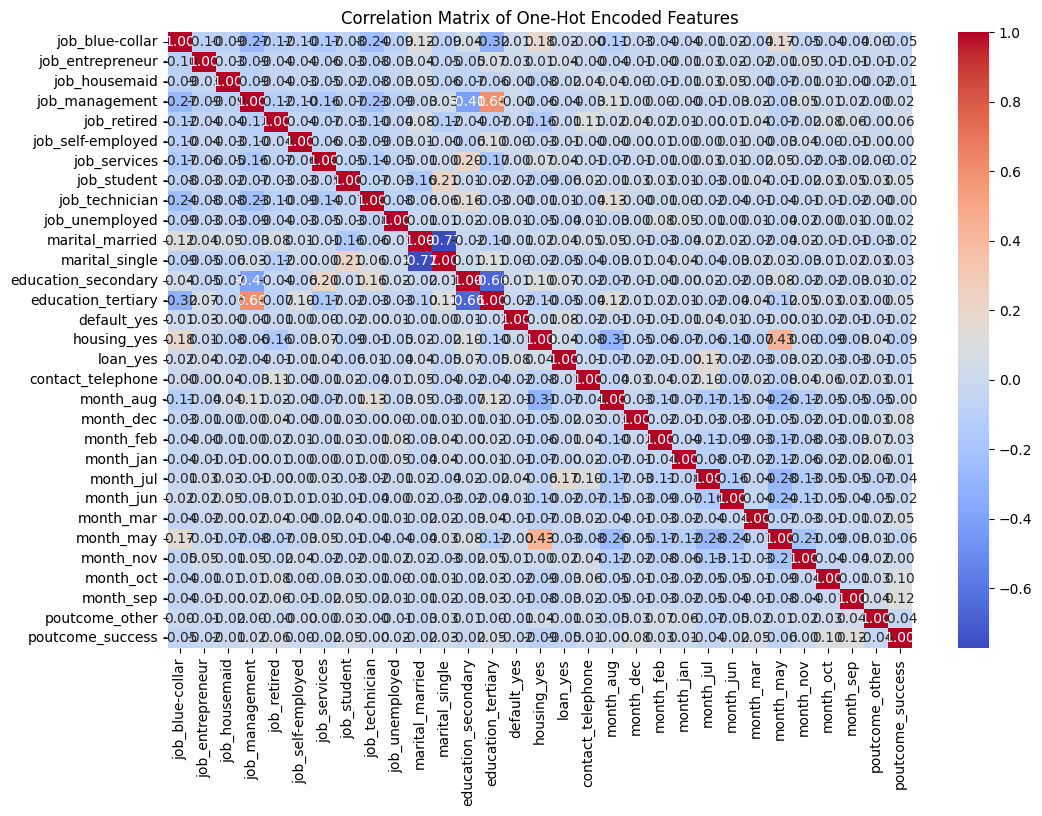

In [110]:
 # handle categorical variables, scaling numerical features, and splitting the data.
    
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Split the data into features and target
X = df.drop('target', axis=1)
y = df['target']

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

### Check for Collinearity Among Categorical Variables

# Convert categorical variables to dummy/indicator variables (for correlation check)
df_dummies = pd.get_dummies(df[categorical_features], drop_first=True)

# Calculate the correlation matrix
correlation_matrix = df_dummies.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of One-Hot Encoded Features')
#plt.show()
plt.savefig('images/Correlation_Matrix.jpg')


In [103]:
# based on the above Correlation, choose the below features

new_categorical_features = ['loan','housing','default','education','job', 'marital', 'education']

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Standardize numerical features
        ('cat', OneHotEncoder(drop='first'), new_categorical_features)  # One-Hot encode categorical features
    ]
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Modeling

In [98]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Define classifiers
classifiers = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC(probability=True)
}

# Store results
results = {}

# Evaluate each classifier
for name, clf in classifiers.items():
    # Create a pipeline with preprocessing and the classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = pipeline.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Store the results
    results[name] = {
        'accuracy': accuracy,
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }

K-Nearest Neighbors Accuracy: 0.8861
              precision    recall  f1-score   support

          no       0.91      0.96      0.94      7985
         yes       0.52      0.29      0.38      1058

    accuracy                           0.89      9043
   macro avg       0.72      0.63      0.66      9043
weighted avg       0.87      0.89      0.87      9043

Logistic Regression Accuracy: 0.8910
              precision    recall  f1-score   support

          no       0.90      0.98      0.94      7985
         yes       0.60      0.21      0.31      1058

    accuracy                           0.89      9043
   macro avg       0.75      0.60      0.63      9043
weighted avg       0.87      0.89      0.87      9043

Decision Tree Accuracy: 0.8538
              precision    recall  f1-score   support

          no       0.92      0.91      0.92      7985
         yes       0.38      0.41      0.40      1058

    accuracy                           0.85      9043
   macro avg       0.65

# 5. Evaluation

In [76]:
# Compare the performance of the models using various metrics.

K-Nearest Neighbors - Accuracy: 0.8961
Logistic Regression - Accuracy: 0.9014
Decision Tree - Accuracy: 0.8734
Support Vector Machine - Accuracy: 0.9034


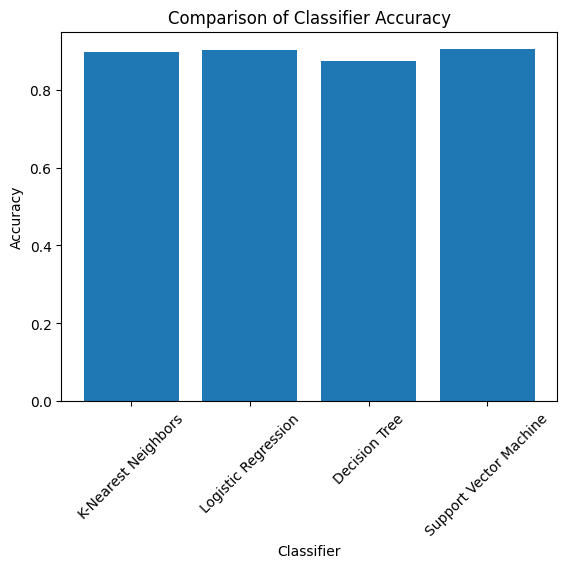

In [77]:
# Compare accuracies
for name, result in results.items():
    print(f"{name} - Accuracy: {result['accuracy']:.4f}")

# Optionally, plot the accuracies
accuracies = [results[name]['accuracy'] for name in classifiers.keys()]
plt.bar(classifiers.keys(), accuracies)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Comparison of Classifier Accuracy')
plt.xticks(rotation=45)
plt.show()


### 5.1 Cross-Validation

Using cross-validation, we can further assess the model's generalization performance. Cross-validation provides a more reliable estimate of a model's performance on unseen data by averaging results over multiple folds.

In [78]:
from sklearn.model_selection import cross_val_score

# Function to evaluate overfitting
def evaluate_overfitting(model, X_train, X_test, y_train, y_test):
    # Training score
    train_score = model.score(X_train, y_train)
    
    # Test score
    test_score = model.score(X_test, y_test)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_mean = cv_scores.mean()
    
    print(f"Training Accuracy: {train_score:.4f}")
    print(f"Test Accuracy: {test_score:.4f}")
    print(f"Cross-Validation Accuracy (mean of 5 folds): {cv_mean:.4f}")
    
    if train_score > test_score + 0.1:
        print("Potential overfitting detected: Training accuracy significantly higher than test accuracy.")
    elif test_score > train_score:
        print("Model is underfitting: Test accuracy is higher than training accuracy.")
    else:
        print("Model is performing consistently between training and test sets.")

# Evaluate all classifiers
for name, clf in classifiers.items():
    print(f"\nEvaluating {name}...")
    
    # Create a pipeline with preprocessing and the classifier
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Evaluate overfitting
    evaluate_overfitting(model, X_train, X_test, y_train, y_test)



Evaluating K-Nearest Neighbors...
Training Accuracy: 0.9242
Test Accuracy: 0.8961
Cross-Validation Accuracy (mean of 5 folds): 0.8949
Model is performing consistently between training and test sets.

Evaluating Logistic Regression...
Training Accuracy: 0.9021
Test Accuracy: 0.9014
Cross-Validation Accuracy (mean of 5 folds): 0.9017
Model is performing consistently between training and test sets.

Evaluating Decision Tree...
Training Accuracy: 1.0000
Test Accuracy: 0.8750
Cross-Validation Accuracy (mean of 5 folds): 0.8756
Potential overfitting detected: Training accuracy significantly higher than test accuracy.

Evaluating Support Vector Machine...
Training Accuracy: 0.9151
Test Accuracy: 0.9034
Cross-Validation Accuracy (mean of 5 folds): 0.9035
Model is performing consistently between training and test sets.


# 6 Interpretation of Results

Visualize the classification methods 

/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


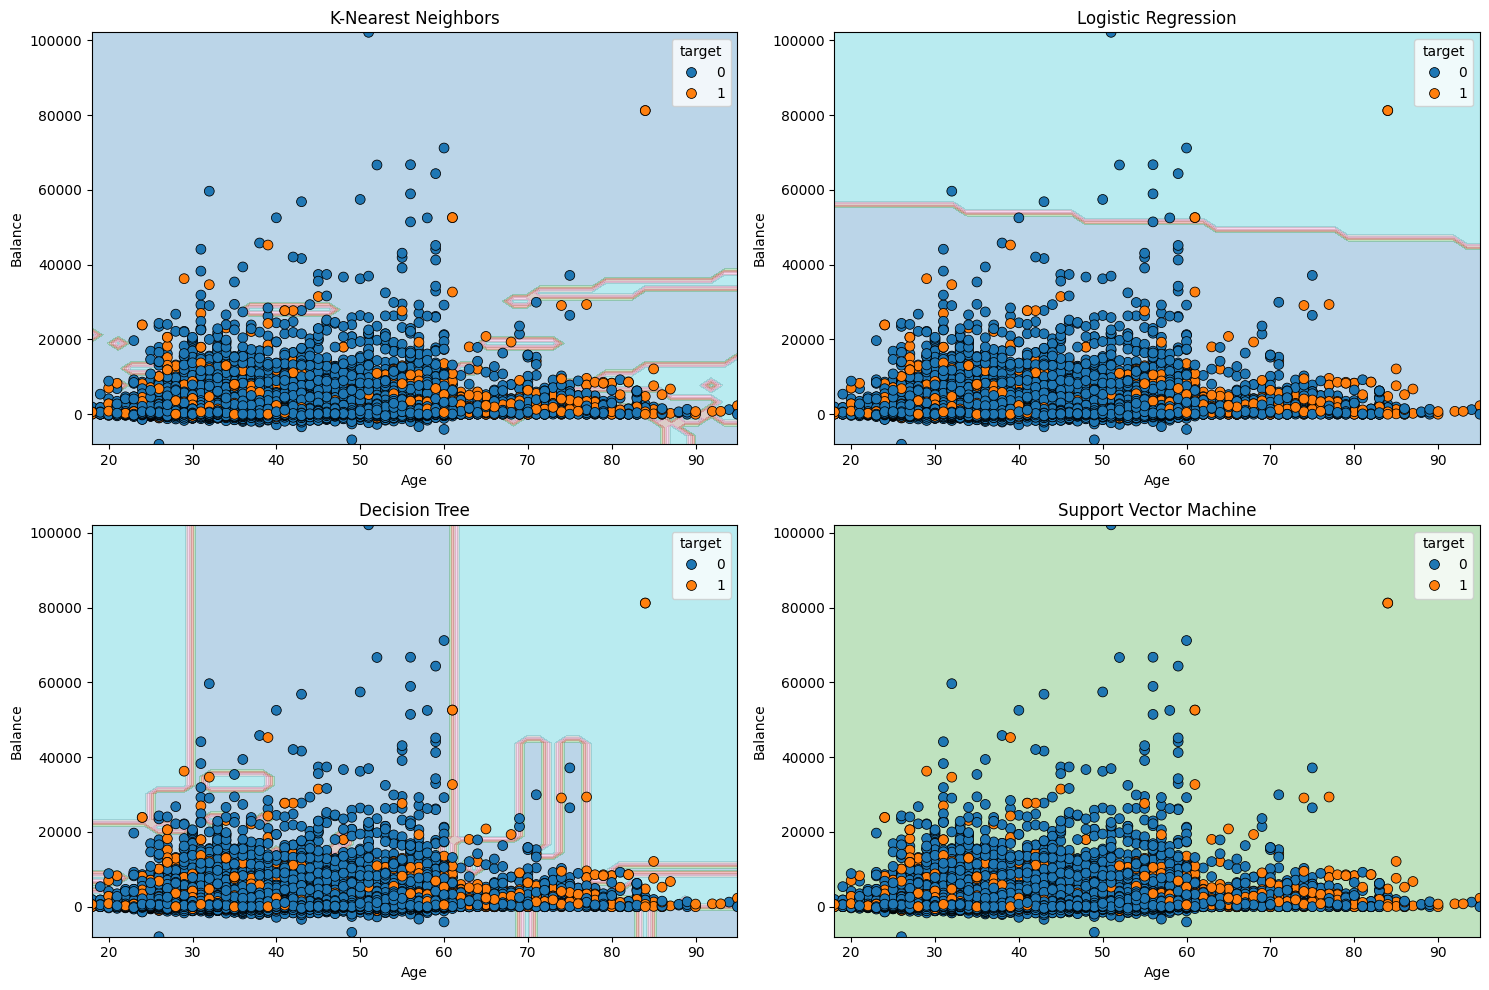

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector

# Select two features for visualization
selected_features = ['age', 'balance']
X = df[selected_features]
y = df['target']

# Encode categorical target
y = y.map({'no': 0, 'yes': 1})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define classifiers
classifiers = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC(kernel='linear')
}

# Prepare the grid for visualization
xx = np.linspace(X_train['age'].min(), X_train['age'].max(), 50)
yy = np.linspace(X_train['balance'].min(), X_train['balance'].max(), 50)
XX, YY = np.meshgrid(xx, yy)
grid = np.c_[XX.ravel(), YY.ravel()]

# Set up the plot
plt.figure(figsize=(15, 10))

# Visualize each classifier's decision boundary
for i, (name, clf) in enumerate(classifiers.items()):
    plt.subplot(2, 2, i + 1)
    
    # Create a pipeline for each classifier
    model = make_pipeline(StandardScaler(), clf)
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict labels for the grid
    labels = model.predict(grid)
    
    # Plot decision boundary
    plt.contourf(XX, YY, labels.reshape(XX.shape), cmap='tab10', alpha=0.3)
    
    # Plot training points
    sns.scatterplot(data=X_train, x='age', y='balance', hue=y_train, palette='tab10', edgecolor='k', s=50)
    
    # Set plot title and labels
    plt.title(f"{name}")
    plt.xlabel('Age')
    plt.ylabel('Balance')

plt.tight_layout()
plt.show()


In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame and 'target' is the outcome variable
# df = pd.DataFrame(data) # Uncomment if you have a DataFrame

# Select only the relevant features
X = df[['job', 'marital', 'education']]
y = df['target']

# Encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['job', 'marital', 'education'])
    ]
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a simple Logistic Regression model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train the model
pipeline.fit(X_train, y_train)

# Visualize decision boundaries for two of the encoded features

# Generate a grid of points covering the feature space
xx, yy = np.linspace(X_train['job'].min(), X_train['job'].max(), 50), np.linspace(X_train['marital'].min(), X_train['marital'].max(), 50)
XX, YY = np.meshgrid(xx, yy)
grid = np.c_[XX.ravel(), YY.ravel()]

# Predict the grid using the trained model
# Note: This assumes you have access to the evaluate_kernel_model function
labels = pipeline.predict(grid).reshape(XX.shape)

# Plot the decision boundary
plt.contourf(XX, YY, labels, cmap='tab10', alpha=0.3)
sns.scatterplot(x='job', y='marital', hue='target', data=df)
plt.show()


TypeError: '<=' not supported between instances of 'str' and 'float'

### 7.1 Features with significant impact:

## 8 Conclusions